In [1]:
from transformers import AutoModelWithLMHead,BertForSequenceClassification, AutoTokenizer, AutoModel,AutoModelForMaskedLM,AutoModelForSequenceClassification
import torch
from torch import nn
import json
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from torch.utils.data import DataLoader,TensorDataset
from transformers import Trainer, TrainingArguments
import pickle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,roc_curve
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [2]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
new_tokens = ["interstitial", "fibrosis", "tubular", "atrophy","antibody","T-cell"]
tokenizer.add_tokens(new_tokens)

6

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [2]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

In [3]:
tokenizer.tokenize("interstitial fibrosis and tubular atrophy. T-cell mediated rejection. antibody ")

['inter',
 '##st',
 '##iti',
 '##al',
 'fi',
 '##bro',
 '##sis',
 'and',
 'tub',
 '##ular',
 'at',
 '##rop',
 '##hy',
 '.',
 't',
 '-',
 'cell',
 'mediated',
 'rejection',
 '.',
 'anti',
 '##body']

In [18]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
tokenizer.tokenize("Trichrome stain shows focal mild interstitial fibrosis and tubular atrophy. ")

['t',
 '##rich',
 '##rome',
 'stain',
 'shows',
 'focal',
 'mild',
 'inter',
 '##st',
 '##iti',
 '##al',
 'fi',
 '##bro',
 '##sis',
 'and',
 'tub',
 '##ular',
 'at',
 '##rop',
 '##hy',
 '.']

# Fine-tune Masked Language Model

In [7]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
data = pd.read_csv("data.csv")

In [4]:
inputs = data["Raw Case Text"].tolist()

In [6]:
input_encoding = tokenizer(inputs,padding="max_length", truncation=True, 
                            return_tensors="pt",max_length=512)

In [7]:
input_encoding['labels'] = input_encoding.input_ids.detach().clone()
input_encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [8]:
rand = torch.rand(input_encoding.input_ids.shape)
mask_arr = (rand < 0.15) * (input_encoding.input_ids != 101) * \
           (input_encoding.input_ids != 102) * (input_encoding.input_ids != 0)
mask_arr

tensor([[False, False, False,  ...,  True, False, False],
        [False, False, False,  ...,  True, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [10]:
len(mask_arr)

3429

In [11]:
mask_pos = [torch.flatten(mask_arr[i].nonzero()).tolist() for i in range(input_encoding.input_ids.shape[0])]

In [12]:
for i in range(input_encoding.input_ids.shape[0]):
    input_encoding.input_ids[i, mask_pos[i]] = 103

In [13]:
class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, encoding):
        self.encoding = encoding
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encoding.items()}
    def __len__(self):
        return len(self.encoding.input_ids)

masked_dataset = MaskedDataset(input_encoding)

In [14]:

training_args = TrainingArguments(
    output_dir='./mlm_results_largeData',          
    num_train_epochs=3,              
    per_device_train_batch_size=8,  
    #per_device_eval_batch_size=64,   
    #warmup_steps=50,                
    #weight_decay=0.01,                          
    logging_steps=100,
    #evaluation_strategy="steps",
    #eval_steps=100,
    #load_best_model_at_end=True,
    save_steps = 100,
    save_total_limit = 10,
    seed = 0
)


trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=masked_dataset,         
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

***** Running training *****
  Num examples = 3429
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1287
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Step,Training Loss
100,0.159000
200,0.070000
300,0.050300
400,0.045100
500,0.032900
600,0.029600
700,0.027900
800,0.029000
900,0.024200
1000,0.019700


Saving model checkpoint to ./mlm_results_largeData/checkpoint-100
Configuration saved in ./mlm_results_largeData/checkpoint-100/config.json
Model weights saved in ./mlm_results_largeData/checkpoint-100/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Saving model checkpoint to ./mlm_results_largeData/checkpoint-200
Configuration saved in ./mlm_results_largeData/checkpoint-200/config.json
Model weights saved in ./mlm_results_largeData/checkpoint-200/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(s

# Test Trained MLM Model

In [3]:
model_renal = AutoModelForMaskedLM.from_pretrained("./mlm_results_largeData/checkpoint-1100")

In [4]:
original_sent = f"Comment: The biopsy shows severe interstitial inflammation and tubulitis (i3/t3), \
which are diagnostic for acute T-cell-mediated rejection, type IB."

masked_sent = f"Comment: The {tokenizer.mask_token} shows {tokenizer.mask_token} interstitial {tokenizer.mask_token} and tubulitis (i3/t3), \
which are {tokenizer.mask_token} for {tokenizer.mask_token} T-cell-mediated {tokenizer.mask_token}, {tokenizer.mask_token} IB."


In [5]:
tokenized_sent = tokenizer.encode(masked_sent, return_tensors="pt")
mask_token_index = torch.where(tokenized_sent == tokenizer.mask_token_id)[1]

mask_token_index

tensor([ 4,  6, 11, 26, 28, 34, 36])

In [6]:
# clinical model
token_logits = model(tokenized_sent).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_3_tokens = torch.topk(mask_token_logits, 3, dim=1).indices.tolist()
print("Original Sentence: \n", original_sent, "\n")
for words in zip(*top_3_tokens):
    new_sent = masked_sent
    for i,token in enumerate(words):
        new_sent = new_sent.replace(tokenizer.mask_token,f'{i}*{tokenizer.decode([token])}*',1)
    print(new_sent,"\n")
    
# token_logits = model(tokenized_sent).logits
# mask_token_logits = token_logits[0, mask_token_index, :]
# top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
# for token in top_5_tokens:
#     print(masked_sent.replace(tokenizer.mask_token,tokenizer.decode([token])))

Original Sentence: 
 Comment: The biopsy shows severe interstitial inflammation and tubulitis (i3/t3), which are diagnostic for acute T-cell-mediated rejection, type IB. 

Comment: The 0*patient* shows 1*increased* interstitial 2*inflammation* and tubulitis (i3/t3), which are 3*concerning* for 4*a* T-cell-mediated 5*process*, 6*and* IB. 

Comment: The 0*CT* shows 1*bilateral* interstitial 2*disease* and tubulitis (i3/t3), which are 3*suspicious* for 4*chronic* T-cell-mediated 5*reaction*, 6*but* IB. 

Comment: The 0*exam* shows 1*new* interstitial 2*process* and tubulitis (i3/t3), which are 3*typical* for 4*possible* T-cell-mediated 5*infection*, 6*no* IB. 



In [7]:
# model_renal
token_logits = model_renal(tokenized_sent).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_3_tokens = torch.topk(mask_token_logits, 3, dim=1).indices.tolist()
print("Original Sentence: \n", original_sent, "\n")
for words in zip(*top_3_tokens):
    new_sent = masked_sent
    for i,token in enumerate(words):
        new_sent = new_sent.replace(tokenizer.mask_token,f'{i}*{tokenizer.decode([token])}*',1)
    print(new_sent,"\n")


Original Sentence: 
 Comment: The biopsy shows severe interstitial inflammation and tubulitis (i3/t3), which are diagnostic for acute T-cell-mediated rejection, type IB. 

Comment: The 0*patient* shows 1*moderate* interstitial 2*inflammation* and tubulitis (i3/t3), which are 3*insufficient* for 4*acute* T-cell-mediated 5*rejection*, 6*type* IB. 

Comment: The 0*specimen* shows 1*widespread* interstitial 2*congestion* and tubulitis (i3/t3), which are 3*suspicious* for 4*chronic* T-cell-mediated 5*reaction*, 6*and* IB. 

Comment: The 0*examination* shows 1*mild* interstitial 2*swelling* and tubulitis (i3/t3), which are 3*concerning* for 4*a* T-cell-mediated 5*disease*, 6*although* IB. 



# Finetune New Model for isRejection 

In [5]:
data = pd.read_csv("data.csv")
inputs1 = data["train_report"].tolist()
label1 = data["isRejection"].tolist()

label = [l for i,l in zip(inputs1,label1) if str(i)!="nan"]
inputs = [i for i in inputs1 if str(i)!="nan"]

In [6]:
train_text, test_text, train_labels, test_labels = train_test_split(
    inputs, label,random_state = 1,stratify=label,test_size=0.2)

In [7]:
class RenalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1} 

In [8]:
train_encodings = tokenizer(train_text,padding="max_length", truncation=True, 
                            return_tensors="pt",max_length=512)
test_encodings = tokenizer(test_text,padding="max_length", truncation=True, 
                            return_tensors="pt",max_length=512)
train_dataset = RenalDataset(train_encodings, train_labels)
test_dataset = RenalDataset(test_encodings, test_labels)
# model_renal = AutoModelForSequenceClassification.from_pretrained("./mlm_results_largeData/checkpoint-1100")
# model_renal = AutoModelForSequenceClassification.from_pretrained("bert-base-cased")
model_renal = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
# model_renal = AutoModelForSequenceClassification.from_pretrained("./mlm_results_largeData_extended_tokenizer/checkpoint-1100")

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [9]:
batch_size = 8
training_args = TrainingArguments(
    output_dir='./fine_bioBERTcased_results_largeData_batch16_wd1e-5',          
    num_train_epochs=20,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*2,   
    warmup_steps=50,                
    weight_decay=1e-5,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6860
<ipython-input-7-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.260800,0.215274,0.944526,0.000000,0.000000,0.000000
200,0.244000,0.292564,0.944526,0.000000,0.000000,0.000000
300,0.266700,0.255284,0.944526,0.000000,0.000000,0.000000
400,0.232300,0.174267,0.944526,0.000000,0.000000,0.000000
500,0.238700,0.259257,0.944526,0.000000,0.000000,0.000000
600,0.240200,0.249368,0.944526,0.000000,0.000000,0.000000
700,0.173600,0.270994,0.945985,0.600000,0.078947,0.139535
800,0.258400,0.212663,0.944526,0.000000,0.000000,0.000000
900,0.192900,0.205264,0.951825,1.000000,0.131579,0.232558
1000,0.215300,0.188147,0.951825,0.727273,0.210526,0.326531


***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-100
Configuration saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-100\config.json
Model weights saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-100\pytorch_model.bin
<ipython-input-7-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluat

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-900
Configuration saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-900\config.json
Model weights saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-900\pytorch_model.bin
Deleting older checkpoint [fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-800] due to args.save_total_limit
<ipython-input-7-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1000
Configuration saved in ./f

Saving model checkpoint to ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1700
Configuration saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1700\config.json
Model weights saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1700\pytorch_model.bin
Deleting older checkpoint [fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1600] due to args.save_total_limit
<ipython-input-7-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2500
Configuration saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2500\config.json
Model weights saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2500\pytorch_model.bin
Deleting older checkpoint [fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2400] due to args.save_total_limit
<ipython-input-7-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

Configuration saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3200\config.json
Model weights saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3200\pytorch_model.bin
Deleting older checkpoint [fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3100] due to args.save_total_limit
<ipython-input-7-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4000
Configuration saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4000\config.json
Model weights saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4000\pytorch_model.bin
Deleting older checkpoint [fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3900] due to args.save_total_limit
<ipython-input-7-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-5000
Configuration saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-5000\config.json
Model weights saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-5000\pytorch_model.bin
Deleting older checkpoint [fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4900] due to args.save_total_limit
<ipython-input-7-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-5100
Configuration saved in

Configuration saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-6000\config.json
Model weights saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-6000\pytorch_model.bin
Deleting older checkpoint [fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-5900] due to args.save_total_limit
<ipython-input-7-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-6100
Configuration saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoint-6100\config.json
Model weights saved in ./fine_bioBERTcased_results_largeData_batch16_wd1e-5\checkpoi

In [7]:
batch_size = 8
training_args = TrainingArguments(
    output_dir='./fine_exkidBERTcased_results_largeData_batch16_wd1e-5',          
    num_train_epochs=20,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*2,   
    warmup_steps=50,                
    weight_decay=1e-5,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 3,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6860
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.255600,0.268791,0.944526,0.000000,0.000000,0.000000
200,0.236500,0.282152,0.944526,0.000000,0.000000,0.000000
300,0.246400,0.229670,0.944526,0.000000,0.000000,0.000000
400,0.210000,0.180696,0.944526,0.000000,0.000000,0.000000
500,0.230300,0.269836,0.944526,0.000000,0.000000,0.000000
600,0.224600,0.220326,0.944526,0.000000,0.000000,0.000000
700,0.187200,0.255382,0.944526,0.000000,0.000000,0.000000
800,0.212400,0.129945,0.962044,0.700000,0.552632,0.617647
900,0.175400,0.119921,0.959124,0.777778,0.368421,0.500000
1000,0.198300,0.170716,0.950365,1.000000,0.105263,0.190476


***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-100
Configuration saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-100\config.json
Model weights saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-100\pytorch_model.bin
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running E

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-900
Configuration saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-900\config.json
Model weights saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-900\pytorch_model.bin
Deleting older checkpoint [fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-600] due to args.save_total_limit
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1000
Configuration sa

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1900
Configuration saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1900\config.json
Model weights saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1900\pytorch_model.bin
Deleting older checkpoint [fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1700] due to args.save_total_limit
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2000
Configuratio

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2900
Configuration saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2900\config.json
Model weights saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2900\pytorch_model.bin
Deleting older checkpoint [fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2700] due to args.save_total_limit
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3000
Configuratio

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3900
Configuration saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3900\config.json
Model weights saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3900\pytorch_model.bin
Deleting older checkpoint [fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3700] due to args.save_total_limit
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4000
Configuratio

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4900
Configuration saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4900\config.json
Model weights saved in ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4900\pytorch_model.bin
Deleting older checkpoint [fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4700] due to args.save_total_limit
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_exkidBERTcased_results_largeData_batch16_wd1e-5\checkpoint-5000
Configuratio

KeyboardInterrupt: 

In [8]:
batch_size = 8
training_args = TrainingArguments(
    output_dir='./fine_vanBERTcased_results_largeData_batch16_wd1e-5',          
    num_train_epochs=20,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*2,   
    warmup_steps=50,                
    weight_decay=1e-5,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2738
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6860
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.247300,0.282160,0.944526,0.000000,0.000000,0.000000
200,0.247600,0.287136,0.944526,0.000000,0.000000,0.000000
300,0.266200,0.268849,0.944526,0.000000,0.000000,0.000000
400,0.256600,0.220962,0.944526,0.000000,0.000000,0.000000
500,0.239000,0.250985,0.944526,0.000000,0.000000,0.000000
600,0.263000,0.242396,0.944526,0.000000,0.000000,0.000000
700,0.224600,0.279922,0.944526,0.000000,0.000000,0.000000
800,0.264300,0.259498,0.944526,0.000000,0.000000,0.000000
900,0.224300,0.268282,0.944526,0.000000,0.000000,0.000000
1000,0.276600,0.253254,0.944526,0.000000,0.000000,0.000000


***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-100
Configuration saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-100\config.json
Model weights saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-100\pytorch_model.bin
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluat

Saving model checkpoint to ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-900
Configuration saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-900\config.json
Model weights saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-900\pytorch_model.bin
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoi

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1800
Configuration saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1800\config.json
Model weights saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1800\pytorch_model.bin
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Eval

Saving model checkpoint to ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2600
Configuration saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2600\config.json
Model weights saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2600\pytorch_model.bin
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model check

Saving model checkpoint to ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3400
Configuration saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3400\config.json
Model weights saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3400\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-500] due to args.save_total_limit
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `z

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4200
Configuration saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4200\config.json
Model weights saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4200\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-1300] due to args.save_total_limit
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

Configuration saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4900\config.json
Model weights saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-4900\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2000] due to args.save_total_limit
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-5700
Configuration saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-5700\config.json
Model weights saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-5700\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-2800] due to args.save_total_limit
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

Configuration saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-6400\config.json
Model weights saved in ./fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-6400\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_largeData_batch16_wd1e-5\checkpoint-3500] due to args.save_total_limit
<ipython-input-5-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

In [9]:
batch_size = 8
training_args = TrainingArguments(
    output_dir='./fine_vanBERT_results_largeData_batch16_wd1e-5',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*2,   
    warmup_steps=50,                
    weight_decay=1e-5,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3430
<ipython-input-4-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.253500,0.239454,0.944526,0.000000,0.000000,0.000000
200,0.245500,0.274639,0.944526,0.000000,0.000000,0.000000
300,0.273100,0.256213,0.944526,0.000000,0.000000,0.000000
400,0.259000,0.239065,0.944526,0.000000,0.000000,0.000000
500,0.246000,0.250157,0.944526,0.000000,0.000000,0.000000
600,0.267500,0.240655,0.944526,0.000000,0.000000,0.000000
700,0.226500,0.263899,0.944526,0.000000,0.000000,0.000000
800,0.271400,0.261025,0.944526,0.000000,0.000000,0.000000
900,0.225500,0.260134,0.944526,0.000000,0.000000,0.000000
1000,0.288900,0.247814,0.944526,0.000000,0.000000,0.000000


***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-100
Configuration saved in ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-100\config.json
Model weights saved in ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-100\pytorch_model.bin
<ipython-input-4-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num

Model weights saved in ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-900\pytorch_model.bin
<ipython-input-4-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-1000
Configuration saved in ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-1000\config.json
Model weights saved in ./fine_vanB

  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-1800
Configuration saved in ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-1800\config.json
Model weights saved in ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-1800\pytorch_model.bin
<ipython-input-4-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\

Model weights saved in ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-2600\pytorch_model.bin
<ipython-input-4-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-2700
Configuration saved in ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-2700\config.json
Model weights saved in ./fine_van

Deleting older checkpoint [fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-500] due to args.save_total_limit
<ipython-input-4-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./fine_vanBERT_results_largeData_batch16_wd1e-5\checkpoint-400 (score: 0.23906463384628296).


In [8]:
batch_size = 8
training_args = TrainingArguments(
    output_dir='./fine_vanBERT_results_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*2,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3430
<ipython-input-4-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.238400,0.232751,0.944526,0.000000,0.000000,0.000000
200,0.244300,0.272742,0.944526,0.000000,0.000000,0.000000
300,0.278000,0.257704,0.944526,0.000000,0.000000,0.000000
400,0.258100,0.236690,0.944526,0.000000,0.000000,0.000000
500,0.245700,0.250994,0.944526,0.000000,0.000000,0.000000
600,0.266800,1.205118,0.055474,0.055474,1.000000,0.105118
700,0.237300,0.266922,0.944526,0.000000,0.000000,0.000000
800,0.271600,0.262928,0.944526,0.000000,0.000000,0.000000
900,0.225800,0.260988,0.944526,0.000000,0.000000,0.000000
1000,0.287400,0.248935,0.944526,0.000000,0.000000,0.000000


***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERT_results_largeData_batch16\checkpoint-100
Configuration saved in ./fine_vanBERT_results_largeData_batch16\checkpoint-100\config.json
Model weights saved in ./fine_vanBERT_results_largeData_batch16\checkpoint-100\pytorch_model.bin
<ipython-input-4-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Bat

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERT_results_largeData_batch16\checkpoint-1000
Configuration saved in ./fine_vanBERT_results_largeData_batch16\checkpoint-1000\config.json
Model weights saved in ./fine_vanBERT_results_largeData_batch16\checkpoint-1000\pytorch_model.bin
<ipython-input-4-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  

<ipython-input-4-f26e59613042>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
C:\Users\ytc19\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_vanBERT_results_largeData_batch16\checkpoint-1900
Configuration saved in ./fine_vanBERT_results_largeData_batch16\checkpoint-1900\config.json
Model weights saved in ./fine_vanBERT_results_largeData_batch16\checkpoint-1900\pytorch_model.bin
Deleting older checkpoint [fine_vanBERT_results_largeD

'fine_vanBERT_results_largeData_batch16\\checkpoint-100' is not in list


In [49]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*2,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

***** Running training *****
  Num examples = 2738
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5145
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.255100,0.289286,0.944526,0.000000,0.000000,0.000000
200,0.245900,0.261555,0.944526,0.000000,0.000000,0.000000
300,0.249400,0.238307,0.944526,0.000000,0.000000,0.000000
400,0.215800,0.183509,0.944526,0.000000,0.000000,0.000000
500,0.219300,0.253758,0.944526,0.000000,0.000000,0.000000
600,0.235800,0.219565,0.944526,0.000000,0.000000,0.000000
700,0.198400,0.244622,0.944526,0.000000,0.000000,0.000000
800,0.226400,0.171581,0.944526,0.000000,0.000000,0.000000
900,0.184300,0.206051,0.944526,0.000000,0.000000,0.000000
1000,0.228300,0.178887,0.944526,0.000000,0.000000,0.000000


***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-100
Configuration saved in ./fine_mlm_results_largeData/checkpoint-100/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-100/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
/project/60490

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-1000
Configuration saved in ./fine_mlm_results_largeData/checkpoint-1000/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-1000/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving mode

Deleting older checkpoint [fine_mlm_results_largeData/checkpoint-1100] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-2200
Configuration saved in ./fine_mlm_results_largeData/checkpoint-2200/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-2200/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData/checkpoint-1200] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

  Batch size = 16
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-3300
Configuration saved in ./fine_mlm_results_largeData/checkpoint-3300/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-3300/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData/checkpoint-2400] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-3400
Configuration saved in ./fine_mlm_results_largeData/checkpoint-3400/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-3400/pytorch_model.bin
Deleting older checkpoint [fine_mlm_res

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-4500
Configuration saved in ./fine_mlm_results_largeData/checkpoint-4500/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-4500/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData/checkpoint-3600] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-4600
Configuration saved in ./fine_mlm_results_largeData/checkpoint-4600/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-4600/pytor

In [49]:
batch_size = 8
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_largeData',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*2,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

***** Running training *****
  Num examples = 2738
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5145
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.255100,0.289286,0.944526,0.000000,0.000000,0.000000
200,0.245900,0.261555,0.944526,0.000000,0.000000,0.000000
300,0.249400,0.238307,0.944526,0.000000,0.000000,0.000000
400,0.215800,0.183509,0.944526,0.000000,0.000000,0.000000
500,0.219300,0.253758,0.944526,0.000000,0.000000,0.000000
600,0.235800,0.219565,0.944526,0.000000,0.000000,0.000000
700,0.198400,0.244622,0.944526,0.000000,0.000000,0.000000
800,0.226400,0.171581,0.944526,0.000000,0.000000,0.000000
900,0.184300,0.206051,0.944526,0.000000,0.000000,0.000000
1000,0.228300,0.178887,0.944526,0.000000,0.000000,0.000000


***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-100
Configuration saved in ./fine_mlm_results_largeData/checkpoint-100/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-100/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
/project/60490

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-1000
Configuration saved in ./fine_mlm_results_largeData/checkpoint-1000/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-1000/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving mode

Deleting older checkpoint [fine_mlm_results_largeData/checkpoint-1100] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-2200
Configuration saved in ./fine_mlm_results_largeData/checkpoint-2200/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-2200/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData/checkpoint-1200] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

  Batch size = 16
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-3300
Configuration saved in ./fine_mlm_results_largeData/checkpoint-3300/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-3300/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData/checkpoint-2400] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-3400
Configuration saved in ./fine_mlm_results_largeData/checkpoint-3400/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-3400/pytorch_model.bin
Deleting older checkpoint [fine_mlm_res

***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-4500
Configuration saved in ./fine_mlm_results_largeData/checkpoint-4500/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-4500/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData/checkpoint-3600] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 16
Saving model checkpoint to ./fine_mlm_results_largeData/checkpoint-4600
Configuration saved in ./fine_mlm_results_largeData/checkpoint-4600/config.json
Model weights saved in ./fine_mlm_results_largeData/checkpoint-4600/pytor

In [ ]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_largeData_batch16',          
    num_train_epochs=15,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 10,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2738
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2580
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.301400,0.224505,0.944526,0.000000,0.000000,0.000000
100,0.216300,0.279459,0.944526,0.000000,0.000000,0.000000
150,0.225200,0.178715,0.944526,0.000000,0.000000,0.000000
200,0.159300,0.144170,0.924088,0.407895,0.815789,0.543860
250,0.150000,0.133488,0.960584,0.823529,0.368421,0.509091
300,0.157100,0.136027,0.951825,0.857143,0.157895,0.266667
350,0.130600,0.200309,0.947445,1.000000,0.052632,0.100000
400,0.152000,0.122523,0.956204,0.833333,0.263158,0.400000
450,0.098000,0.112497,0.969343,0.904762,0.500000,0.644068
500,0.148200,0.115251,0.966423,0.894737,0.447368,0.596491


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_mlm_results_largeData_batch16/checkpoint-50
Configuration saved in ./fine_mlm_results_largeData_batch16/checkpoint-50/config.json
Model weights saved in ./fine_mlm_results_largeData_batch16/checkpoint-50/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData_batch16/checkpoint-200] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_largeData_batch16/checkpoint-550
Configuration saved in ./fine_mlm_results_largeData_batch16/checkpoint-550/config.json
Model weights saved in ./fine_mlm_results_largeData_batch16/checkpoint-550/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData_batch16/checkpoint-50] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_largeData_batch16/checkpoint-600
Configuration saved in ./fine_mlm_results_largeData_batch16/checkpoint-600/config.json
Model weights saved in ./fine_ml

Configuration saved in ./fine_mlm_results_largeData_batch16/checkpoint-1100/config.json
Model weights saved in ./fine_mlm_results_largeData_batch16/checkpoint-1100/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData_batch16/checkpoint-600] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_largeData_batch16/checkpoint-1150
Configuration saved in ./fine_mlm_results_largeData_batch16/checkpoint-1150/config.json
Model weights saved in ./fine_mlm_results_largeData_batch16/checkpoint-1150/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData_batch16/checkpoint-650] due 

Deleting older checkpoint [fine_mlm_results_largeData_batch16/checkpoint-1200] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_largeData_batch16/checkpoint-1700
Configuration saved in ./fine_mlm_results_largeData_batch16/checkpoint-1700/config.json
Model weights saved in ./fine_mlm_results_largeData_batch16/checkpoint-1700/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_largeData_batch16/checkpoint-1250] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to 

In [8]:
fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./fine_mlm_results/checkpoint-360",num_labels=2)
test_trainer = Trainer(fine_tuned_model) 

new_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./fine_mlm_results_largeData_batch16/checkpoint-1450",num_labels=2)
new_test_trainer = Trainer(new_fine_tuned_model)

cli_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./fine_cli_results_largeData/checkpoint-2500",num_labels=2)
cli_test_trainer = Trainer(cli_fine_tuned_model)

loading configuration file ./fine_mlm_results_largeData_batch16/checkpoint-1450/config.json
Model config BertConfig {
  "_name_or_path": "./fine_mlm_results_largeData_batch16/checkpoint-1450",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file ./fine_mlm_results_largeData_batch16/checkpoint-1450/pytorch_model.bin
All model checkpoint weights were used when initializing Be

### Test dataset report on old model (old Kidney BERT+Fine-tune)

In [56]:
raw_pred,_,_=test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

***** Running Prediction *****
  Num examples = 685
  Batch size = 8
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[[612  35]
 [ 16  22]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       647
           1       0.39      0.58      0.46        38

    accuracy                           0.93       685
   macro avg       0.68      0.76      0.71       685
weighted avg       0.94      0.93      0.93       685



### Test dataset report on clinical BERT model (Clinical BERT+Fine-tune)

In [15]:
raw_pred,_,_=cli_test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

***** Running Prediction *****
  Num examples = 685
  Batch size = 8
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[[642   5]
 [ 13  25]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       647
           1       0.83      0.66      0.74        38

    accuracy                           0.97       685
   macro avg       0.91      0.83      0.86       685
weighted avg       0.97      0.97      0.97       685



### Test dataset report on new model (new Kidney BERT+Fine-tune)

In [9]:
raw_pred,_,_=new_test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

***** Running Prediction *****
  Num examples = 685
  Batch size = 8
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[[643   4]
 [ 12  26]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       647
           1       0.87      0.68      0.76        38

    accuracy                           0.98       685
   macro avg       0.92      0.84      0.88       685
weighted avg       0.98      0.98      0.98       685



***** Running Prediction *****
  Num examples = 685
  Batch size = 8
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
No handles with labels found to put in legend.


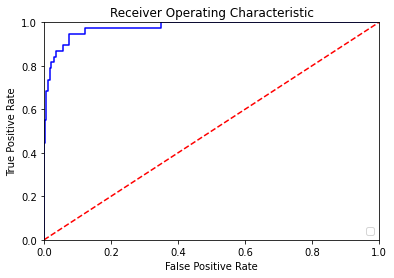

In [33]:
raw_pred,_,_=new_test_trainer.predict(test_dataset) 
fpr, tpr, threshold = roc_curve(test_labels,raw_pred[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
fpr, tpr, threshold

(array([0.        , 0.        , 0.        , 0.00309119, 0.00309119,
        0.00463679, 0.00463679, 0.00618238, 0.00618238, 0.01081917,
        0.01081917, 0.01700155, 0.01700155, 0.01854714, 0.01854714,
        0.02009274, 0.02009274, 0.0309119 , 0.0309119 , 0.03554869,
        0.03554869, 0.05564142, 0.05564142, 0.07418856, 0.07418856,
        0.07573416, 0.07573416, 0.12210201, 0.12210201, 0.34775889,
        0.34775889, 0.67697063, 0.68006182, 0.72488408, 0.72797527,
        0.91962906, 0.92272025, 1.        ]),
 array([0.        , 0.02631579, 0.44736842, 0.44736842, 0.55263158,
        0.55263158, 0.60526316, 0.60526316, 0.68421053, 0.68421053,
        0.73684211, 0.73684211, 0.76315789, 0.76315789, 0.78947368,
        0.78947368, 0.81578947, 0.81578947, 0.84210526, 0.84210526,
        0.86842105, 0.86842105, 0.89473684, 0.89473684, 0.92105263,
        0.92105263, 0.94736842, 0.94736842, 0.97368421, 0.97368421,
        1.        , 1.        , 1.        , 1.        , 1.        ,
  

In [37]:
pred_labels = [1 if x > -5.330841 else 0 for x in raw_pred[:,1]]
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

[[568  79]
 [  2  36]]
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       647
           1       0.31      0.95      0.47        38

    accuracy                           0.88       685
   macro avg       0.65      0.91      0.70       685
weighted avg       0.96      0.88      0.91       685



In [8]:
model_cli = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [9]:
batch_size=16
training_args = TrainingArguments(
    output_dir='./fine_cli_results_largeData',          
    num_train_epochs=15,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=100*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=100*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 100*16/batch_size,
    save_total_limit = 5,
    seed = 0
)


trainer = Trainer(
    model=model_cli,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

***** Running training *****
  Num examples = 2738
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2580
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.263500,0.247531,0.944526,0.000000,0.000000,0.000000
200,0.217700,0.176730,0.944526,0.000000,0.000000,0.000000
300,0.186500,0.127405,0.945985,0.666667,0.052632,0.097561
400,0.160500,0.145680,0.954745,0.888889,0.210526,0.340426
500,0.140500,0.136721,0.947445,1.000000,0.052632,0.100000
600,0.111500,0.116155,0.969343,0.757576,0.657895,0.704225
700,0.119800,0.097637,0.975182,0.838710,0.684211,0.753623
800,0.087800,0.160207,0.970803,1.000000,0.473684,0.642857
900,0.093400,0.095625,0.970803,0.846154,0.578947,0.687500
1000,0.048400,0.132961,0.975182,0.888889,0.631579,0.738462


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_cli_results_largeData/checkpoint-100
Configuration saved in ./fine_cli_results_largeData/checkpoint-100/config.json
Model weights saved in ./fine_cli_results_largeData/checkpoint-100/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
/project/60490

/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cli_results_largeData/checkpoint-1300
Configuration saved in ./fine_cli_results_largeData/checkpoint-1300/config.json
Model weights saved in ./fine_cli_results_largeData/checkpoint-1300/pytorch_model.bin
Deleting older checkpoint [fine_cli_results_largeData/checkpoint-800] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys

Configuration saved in ./fine_cli_results_largeData/checkpoint-2400/config.json
Model weights saved in ./fine_cli_results_largeData/checkpoint-2400/pytorch_model.bin
Deleting older checkpoint [fine_cli_results_largeData/checkpoint-2000] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cli_results_largeData/checkpoint-2500
Configuration saved in ./fine_cli_results_largeData/checkpoint-2500/config.json
Model weights saved in ./fine_cli_results_largeData/checkpoint-2500/pytorch_model.bin
Deleting older checkpoint [fine_cli_results_largeData/checkpoint-2100] due to args.save_total_limit
/project/6049037/ytc1997/rena

TrainOutput(global_step=2580, training_loss=0.062025848511324894, metrics={'train_runtime': 2688.5228, 'train_samples_per_second': 15.276, 'train_steps_per_second': 0.96, 'total_flos': 1.08059710436352e+16, 'train_loss': 0.062025848511324894, 'epoch': 15.0})

### Training dataset report

In [18]:
raw_pred,_,_=test_trainer.predict(train_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(train_labels,pred_labels))
print(classification_report(train_labels,pred_labels))

***** Running Prediction *****
  Num examples = 193
  Batch size = 8
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[[143   0]
 [  0  50]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00        50

    accuracy                           1.00       193
   macro avg       1.00      1.00      1.00       193
weighted avg       1.00      1.00      1.00       193



### Inference on Diagnosis

In [19]:
label_diag = []
inputs_diag = []
with torch.no_grad():
    for k,v in data.items():
        label_diag.append(v["isRejection"])
        inputs_diag.append(" ".join(v["diag"]))
        
diag_encodings = tokenizer(inputs_diag,padding="max_length", truncation=True, 
                            return_tensors="pt",max_length=512)
diag_dataset = RenalDataset(diag_encodings, label_diag)

raw_pred_diag,_,_=test_trainer.predict(diag_dataset) 

pred_labels_diag = np.argmax(raw_pred_diag, axis=1)
print(confusion_matrix(label_diag,pred_labels_diag))
print(classification_report(label_diag,pred_labels_diag))



***** Running Prediction *****
  Num examples = 242
  Batch size = 8
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[[179   0]
 [ 63   0]]
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       179
           1       0.00      0.00      0.00        63

    accuracy                           0.74       242
   macro avg       0.37      0.50      0.43       242
weighted avg       0.55      0.74      0.63       242



/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

# Finetune New Model for isPolyomavirus

In [15]:
data = pd.read_csv("data.csv")
inputs1 = data["train_report"].tolist()
label1 = data["poly_infection"].tolist()

In [16]:
label = [l for i,l in zip(inputs1,label1) if str(i)!="nan"]
inputs = [i for i in inputs1 if str(i)!="nan"]

In [17]:
train_text, test_text, train_labels, test_labels = train_test_split(
    inputs, label,random_state = 1,stratify=label,test_size=0.2)

In [18]:
class RenalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1} 

In [19]:
train_encodings = tokenizer(train_text,padding="max_length", truncation=True, 
                            return_tensors="pt",max_length=512)
test_encodings = tokenizer(test_text,padding="max_length", truncation=True, 
                            return_tensors="pt",max_length=512)
train_dataset = RenalDataset(train_encodings, train_labels)
test_dataset = RenalDataset(test_encodings, test_labels)
model_renal = AutoModelForSequenceClassification.from_pretrained("./mlm_results_largeData/checkpoint-1100")

loading configuration file ./mlm_results_largeData/checkpoint-1100/config.json
Model config BertConfig {
  "_name_or_path": "./mlm_results_largeData/checkpoint-1100",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file ./mlm_results_largeData/checkpoint-1100/pytorch_model.bin
Some weights of the model checkpoint at ./mlm_results_largeData/checkpoint-1100 were not used when initializing BertForSequenceClassification: ['cls.predictions.

In [8]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_poly_largeData_batch16',          
    num_train_epochs=15,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=100*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=100*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 100*16/batch_size,
    save_total_limit = 10,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

***** Running training *****
  Num examples = 2738
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2580
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.128200,0.052590,0.991241,0.000000,0.000000,0.000000
200,0.053300,0.053335,0.991241,0.000000,0.000000,0.000000
300,0.058400,0.049897,0.991241,0.000000,0.000000,0.000000
400,0.051200,0.055769,0.991241,0.000000,0.000000,0.000000
500,0.065400,0.046489,0.991241,0.000000,0.000000,0.000000
600,0.050400,0.050088,0.991241,0.000000,0.000000,0.000000
700,0.056900,0.050370,0.991241,0.000000,0.000000,0.000000
800,0.050900,0.054801,0.991241,0.000000,0.000000,0.000000
900,0.055700,0.050254,0.991241,0.000000,0.000000,0.000000
1000,0.055600,0.048542,0.991241,0.000000,0.000000,0.000000


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_mlm_results_poly_largeData_batch16/checkpoint-100
Configuration saved in ./fine_mlm_results_poly_largeData_batch16/checkpoint-100/config.json
Model weights saved in ./fine_mlm_results_poly_largeData_batch16/checkpoint-100/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples

Model weights saved in ./fine_mlm_results_poly_largeData_batch16/checkpoint-900/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./fine_mlm_results_poly_largeData_batch16/checkpoint-1000
Configuration saved in ./fine_mlm_results_poly_largeData_batch16/checkpoint-1000/config.json
Model weights saved in ./fine_mlm_results_p

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_poly_largeData_batch16/checkpoint-1800
Configuration saved in ./fine_mlm_results_poly_largeData_batch16/checkpoint-1800/config.json
Model weights saved in ./fine_mlm_results_poly_largeData_batch16/checkpoint-1800/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_poly_largeData_batch16/checkpoint-800] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

loading configuration file ./fine_mlm_results_poly_largeData_batch16/checkpoint-1500/config.json
Model config BertConfig {
  "_name_or_path": "./fine_mlm_results_poly_largeData_batch16/checkpoint-1500",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file ./fine_mlm_results_poly_largeData_batch16/checkpoint-1500/pytorch_model.bin
All model checkpoint weights were used when 

No handles with labels found to put in legend.


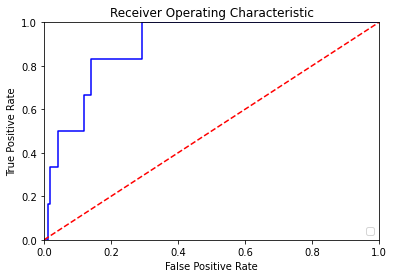

In [21]:
poly_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./fine_mlm_results_poly_largeData_batch16/checkpoint-1500",num_labels=2)
poly_test_trainer = Trainer(poly_fine_tuned_model) 
raw_pred,_,_=poly_test_trainer.predict(test_dataset) 
fpr, tpr, threshold = roc_curve(test_labels,raw_pred[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [22]:
fpr, tpr, threshold

(array([0.        , 0.00147275, 0.01030928, 0.01030928, 0.0191458 ,
        0.0191458 , 0.04270987, 0.04270987, 0.08836524, 0.09131075,
        0.11929308, 0.11929308, 0.13991163, 0.13991163, 0.2916053 ,
        0.2916053 , 1.        ]),
 array([0.        , 0.        , 0.        , 0.16666667, 0.16666667,
        0.33333333, 0.33333333, 0.5       , 0.5       , 0.5       ,
        0.5       , 0.66666667, 0.66666667, 0.83333333, 0.83333333,
        1.        , 1.        ]),
 array([ 1.0451297 ,  0.04512969, -0.7204098 , -0.77648747, -1.1161269 ,
        -1.1819223 , -1.5454829 , -1.5538887 , -2.0171494 , -2.0263326 ,
        -2.2912147 , -2.2997682 , -2.4341824 , -2.4374282 , -3.0565283 ,
        -3.0578592 , -3.898161  ], dtype=float32))

In [26]:
pred_labels = [1 if x > -2.4374282 else 0 for x in raw_pred[:,1]]
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

[[584  95]
 [  2   4]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       679
           1       0.04      0.67      0.08         6

    accuracy                           0.86       685
   macro avg       0.52      0.76      0.50       685
weighted avg       0.99      0.86      0.92       685



# Finetune New Model for IFTA 4labels

In [3]:
data = pd.read_csv("data.csv")
inputs1 = data["train_report"].tolist()
label1 = data["IFTA"].tolist()

In [4]:
label2 = [l for i,l in zip(inputs1,label1) if str(i)!="nan"]
label = [0 if l in ["nosig","minimal","noinfo"] else 1 for l in label2]
inputs = [i for i in inputs1 if str(i)!="nan"]

In [4]:
label2 = [l for i,l in zip(inputs1,label1) if str(i)!="nan"]
label = [0 if l in ["nosig","minimal","noinfo"] else (1 if l=="mild" else (2 if l=="moderate" else 3)) for l in label2]
inputs = [i for i in inputs1 if str(i)!="nan"]

In [5]:
train_text, test_text, train_labels, test_labels = train_test_split(
    inputs, label,random_state = 1,stratify=label,test_size=0.2)

In [6]:
class RenalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average="micro")
    precision = precision_score(y_true=labels, y_pred=pred,average="micro")
    f1 = f1_score(y_true=labels, y_pred=pred,average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1} 

In [7]:
train_encodings = tokenizer(train_text,padding="max_length", truncation=True, 
                            return_tensors="pt",max_length=512)
test_encodings = tokenizer(test_text,padding="max_length", truncation=True, 
                            return_tensors="pt",max_length=512)
train_dataset = RenalDataset(train_encodings, train_labels)
test_dataset = RenalDataset(test_encodings, test_labels)
# model_renal = AutoModelForSequenceClassification.from_pretrained("./mlm_results_largeData/checkpoint-1100",num_labels=4)
# model_renal = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",num_labels=4)
model_renal = AutoModelForSequenceClassification.from_pretrained("./mlm_results_largeData_extended_tokenizer/checkpoint-1100",num_labels=4)
# model_renal = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1",num_labels=4)


Some weights of the model checkpoint at ./mlm_results_largeData_extended_tokenizer/checkpoint-1100 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [8]:
batch_size = 16
model_cli = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",num_labels=4)
training_args = TrainingArguments(
    output_dir='./fine_cliBERT_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_cli,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.053200,0.791820,0.703650,0.703650,0.703650,0.652951
100,0.813400,0.706268,0.693431,0.693431,0.693431,0.655492
150,0.749000,0.694519,0.712409,0.712409,0.712409,0.669204
200,0.695900,0.753696,0.680292,0.680292,0.680292,0.628765
250,0.724600,0.639975,0.734307,0.734307,0.734307,0.729725
300,0.663800,0.695442,0.719708,0.719708,0.719708,0.705799
350,0.659200,0.666660,0.703650,0.703650,0.703650,0.666407
400,0.664100,0.638096,0.725547,0.725547,0.725547,0.729343
450,0.557500,0.639439,0.713869,0.713869,0.713869,0.689931
500,0.554700,0.587391,0.764964,0.764964,0.764964,0.751725


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1000] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in .

Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-550\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-550\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-450] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpo

Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1050\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1000] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_ba

Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1550] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy cons

TrainOutput(global_step=1720, training_loss=0.43524026149927186, metrics={'train_runtime': 1176.4362, 'train_samples_per_second': 23.274, 'train_steps_per_second': 1.462, 'total_flos': 7204110059028480.0, 'train_loss': 0.43524026149927186, 'epoch': 10.0})

In [8]:
batch_size = 16
model_cli = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",num_labels=4)
training_args = TrainingArguments(
    output_dir='./fine_cliBERT_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_cli,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.117900,0.825132,0.683212,0.683212,0.683212,0.638509
100,0.815600,0.693323,0.710949,0.710949,0.710949,0.670370
150,0.746800,0.732824,0.670073,0.670073,0.670073,0.620212
200,0.686100,0.638288,0.731387,0.731387,0.731387,0.685744
250,0.698300,0.688315,0.719708,0.719708,0.719708,0.719716
300,0.666400,0.628203,0.748905,0.748905,0.748905,0.737862
350,0.635400,0.658185,0.699270,0.699270,0.699270,0.682683
400,0.657600,0.647326,0.694891,0.694891,0.694891,0.698469
450,0.589800,0.621179,0.725547,0.725547,0.725547,0.713611
500,0.570200,0.686406,0.693431,0.693431,0.693431,0.703207


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in ./

Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-550\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-550\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpo

Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1050\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-950] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_bat

Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1550] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy cons

TrainOutput(global_step=1720, training_loss=0.4814317460670028, metrics={'train_runtime': 1176.9718, 'train_samples_per_second': 23.263, 'train_steps_per_second': 1.461, 'total_flos': 7204110059028480.0, 'train_loss': 0.4814317460670028, 'epoch': 10.0})

In [8]:
batch_size = 16
model_cli = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",num_labels=4)
training_args = TrainingArguments(
    output_dir='./fine_cliBERT_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_cli,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.024100,0.798756,0.675912,0.675912,0.675912,0.675912
100,0.838400,0.695720,0.699270,0.699270,0.699270,0.699270
150,0.759500,0.719402,0.693431,0.693431,0.693431,0.693431
200,0.686500,0.646434,0.737226,0.737226,0.737226,0.737226
250,0.695400,0.651195,0.721168,0.721168,0.721168,0.721168
300,0.661700,0.631863,0.727007,0.727007,0.727007,0.727007
350,0.642400,0.673121,0.702190,0.702190,0.702190,0.702190
400,0.657700,0.626138,0.734307,0.734307,0.734307,0.734307
450,0.571400,0.613128,0.731387,0.731387,0.731387,0.731387
500,0.571800,0.593151,0.750365,0.750365,0.750365,0.750365


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100\config.json
Model weights saved in ./fine_cliBERT_results

Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-450] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-500] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct

<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1050] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1550] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1650
Configuration sav

TrainOutput(global_step=1720, training_loss=0.4371066925137542, metrics={'train_runtime': 1193.3504, 'train_samples_per_second': 22.944, 'train_steps_per_second': 1.441, 'total_flos': 7204110059028480.0, 'train_loss': 0.4371066925137542, 'epoch': 10.0})

In [ ]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_bioBERT_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=20,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3440
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.082600,0.832251,0.649635,0.649635,0.649635,0.594353
100,0.803200,0.725592,0.708029,0.708029,0.708029,0.669213
150,0.773700,0.711215,0.716788,0.716788,0.716788,0.671332
200,0.662900,0.628336,0.751825,0.751825,0.751825,0.738075
250,0.699400,0.666878,0.694891,0.694891,0.694891,0.693153
300,0.646600,0.585060,0.757664,0.757664,0.757664,0.744130
350,0.609100,0.591232,0.748905,0.748905,0.748905,0.733569
400,0.614200,0.613890,0.741606,0.741606,0.741606,0.738821
450,0.540000,0.624093,0.745985,0.745985,0.745985,0.728393
500,0.536800,0.604265,0.753285,0.753285,0.753285,0.750196


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-600] due to args.save_total_limit
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1650] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size =

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-550
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-550\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-550\pytorch_model.bin
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in

Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1050
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1050\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1050\pytorch_model.bin
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1000] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint

Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1550\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1550\pytorch_model.bin
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\ch

Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-2050\pytorch_model.bin
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-2000] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-2100
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-2100\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-2100\pytorch_model.bin
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_ba

Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-2500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-2600
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-2600\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-2600\pytorch_model.bin
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-2550] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy cons

In [9]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_bioBERT_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 3,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1720
<ipython-input-7-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.990500,0.758615,0.702190,0.702190,0.702190,0.702190
100,0.792100,0.691256,0.731387,0.731387,0.731387,0.731387
150,0.745400,0.681075,0.712409,0.712409,0.712409,0.712409
200,0.661200,0.648920,0.744526,0.744526,0.744526,0.744526
250,0.670400,0.661237,0.729927,0.729927,0.729927,0.729927
300,0.656200,0.629094,0.732847,0.732847,0.732847,0.732847
350,0.645600,0.592628,0.754745,0.754745,0.754745,0.754745
400,0.623900,0.591421,0.744526,0.744526,0.744526,0.744526
450,0.519700,0.592813,0.756204,0.756204,0.756204,0.756204
500,0.536500,0.627654,0.741606,0.741606,0.741606,0.741606


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
<ipython-input-7-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-100\config.json
Model weights saved in ./fine_bioBERT_results

<ipython-input-7-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-400] due to args.save_total_limit
<ipython-input-7-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1000] due to args.save_total_limit
<ipython-input-7-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1150
Configuration sav

  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\config.json
Model weights saved in ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\pytorch_model.bin
Deleting older checkpoint [fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1500] due to args.save_total_limit
<ipython-input-7-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_bioBERT_results_ifta_4labels_largeData_batch16\checkpoint-1650
Configuration saved in ./fine_bioBERT_results_ifta_4labels_largeData_

TrainOutput(global_step=1720, training_loss=0.4045818965102351, metrics={'train_runtime': 1178.3204, 'train_samples_per_second': 23.236, 'train_steps_per_second': 1.46, 'total_flos': 7204110059028480.0, 'train_loss': 0.4045818965102351, 'epoch': 10.0})

In [ ]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_ifta_4labels_largeData_batch16_extoken',          
    num_train_epochs=15,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2580
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.064600,0.756067,0.678832,0.678832,0.678832,0.633415
100,0.778400,0.692418,0.697810,0.697810,0.697810,0.695014
150,0.745400,0.676375,0.706569,0.706569,0.706569,0.670293
200,0.654000,0.611749,0.748905,0.748905,0.748905,0.741708
250,0.687600,0.619887,0.728467,0.728467,0.728467,0.722257
300,0.616300,0.580796,0.757664,0.757664,0.757664,0.751332
350,0.593600,0.595783,0.738686,0.738686,0.738686,0.729576
400,0.597700,0.610067,0.731387,0.731387,0.731387,0.726758
450,0.512400,0.632559,0.737226,0.737226,0.737226,0.729761
500,0.526000,0.657278,0.716788,0.716788,0.716788,0.722523


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-50
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-50\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-50\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-450] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-100
Confi

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-550
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-550\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-550\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-600
Co

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1050
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1050\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1050\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1000] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-11

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1550
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1550\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1550\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_ifta_4labels_largeData_batch16_extoken',          
    num_train_epochs=15,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2580
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.040000,0.747587,0.694891,0.694891,0.694891,0.670091
100,0.752500,0.661478,0.709489,0.709489,0.709489,0.667099
150,0.734500,0.634644,0.727007,0.727007,0.727007,0.698857
200,0.638800,0.644422,0.710949,0.710949,0.710949,0.710006
250,0.662300,0.622456,0.710949,0.710949,0.710949,0.698836
300,0.625600,0.595209,0.745985,0.745985,0.745985,0.736187
350,0.604900,0.584894,0.756204,0.756204,0.756204,0.750801
400,0.586500,0.630096,0.729927,0.729927,0.729927,0.726158
450,0.528200,0.584605,0.754745,0.754745,0.754745,0.751707
500,0.489500,0.620400,0.744526,0.744526,0.744526,0.746969


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-50
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-50\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-50\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-650] due to args.save_total_limit
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1650] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples 

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-550
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-550\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-550\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-600
Co

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1050
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1050\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1050\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1000] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-11

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1550
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1550\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1550\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-16

In [8]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_ifta_4labels_largeData_batch16_extoken',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 3,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1720
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.048700,0.814612,0.642336,0.642336,0.642336,0.642336
100,0.771500,0.712199,0.713869,0.713869,0.713869,0.713869
150,0.740900,0.676847,0.708029,0.708029,0.708029,0.708029
200,0.654700,0.611833,0.759124,0.759124,0.759124,0.759124
250,0.644400,0.614967,0.725547,0.725547,0.725547,0.725547
300,0.636400,0.590438,0.757664,0.757664,0.757664,0.757664
350,0.594900,0.598589,0.744526,0.744526,0.744526,0.744526
400,0.572400,0.613279,0.745985,0.745985,0.745985,0.745985
450,0.512200,0.611483,0.745985,0.745985,0.745985,0.745985
500,0.517200,0.671728,0.716788,0.716788,0.716788,0.716788


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-50
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-50\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-50\pytorch_model.bin
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-100
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-100\config.json
Model weights saved in ./

Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-450] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-600
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-600\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-300] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarnin

Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-950] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1100
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1100\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1000] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWa

Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1550\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1450] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1600
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1600\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_extoken\checkpoint-1600\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4lab

In [8]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_vanBERTcased_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1720
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.129500,0.944522,0.601460,0.601460,0.601460,0.563856
100,0.874700,0.726332,0.693431,0.693431,0.693431,0.654389
150,0.804800,0.763113,0.672993,0.672993,0.672993,0.626272
200,0.727100,0.737253,0.716788,0.716788,0.716788,0.664686
250,0.731900,0.716758,0.709489,0.709489,0.709489,0.713015
300,0.678700,0.668982,0.715328,0.715328,0.715328,0.703040
350,0.676200,0.679453,0.716788,0.716788,0.716788,0.706461
400,0.663500,0.682153,0.703650,0.703650,0.703650,0.705735
450,0.600400,0.643007,0.725547,0.725547,0.725547,0.708104
500,0.603400,0.775869,0.659854,0.659854,0.659854,0.676687


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-600] due to args.save_total_limit
Deleting older checkpoint [fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1250] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num exam

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-550
Configuration saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-550\config.json
Model weights saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-550\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-450] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-6

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1050
Configuration saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1050\config.json
Model weights saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1050\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1000] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoi

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1550
Configuration saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1550\config.json
Model weights saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1550\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoi

In [8]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_vanBERTcased_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1720
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.070400,0.903064,0.595620,0.595620,0.595620,0.595620
100,0.869100,0.734066,0.705109,0.705109,0.705109,0.705109
150,0.795300,0.821656,0.665693,0.665693,0.665693,0.665693
200,0.739800,0.672216,0.721168,0.721168,0.721168,0.721168
250,0.737200,0.667618,0.716788,0.716788,0.716788,0.716788
300,0.689900,0.671694,0.721168,0.721168,0.721168,0.721168
350,0.678200,0.665106,0.709489,0.709489,0.709489,0.709489
400,0.676300,0.658970,0.713869,0.713869,0.713869,0.713869
450,0.605300,0.624236,0.728467,0.728467,0.728467,0.728467
500,0.572800,0.694177,0.705109,0.705109,0.705109,0.705109


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-100\config.json
Model weights saved 

Model weights saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-550\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-400] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_

Configuration saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1050\config.json
Model weights saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1050\pytorch_model.bin
Deleting older checkpoint [fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-950] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_vanBERTcased_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_vanBERTcased_results_ifta

KeyboardInterrupt: 

In [8]:
batch_size = 16
model_cli = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",num_labels=4)
training_args = TrainingArguments(
    output_dir='./fine_cliBERT_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_cli,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.024100,0.798756,0.675912,0.675912,0.675912,0.675912
100,0.838400,0.695720,0.699270,0.699270,0.699270,0.699270
150,0.759500,0.719402,0.693431,0.693431,0.693431,0.693431
200,0.686500,0.646434,0.737226,0.737226,0.737226,0.737226
250,0.695400,0.651195,0.721168,0.721168,0.721168,0.721168
300,0.661700,0.631863,0.727007,0.727007,0.727007,0.727007
350,0.642400,0.673121,0.702190,0.702190,0.702190,0.702190
400,0.657700,0.626138,0.734307,0.734307,0.734307,0.734307
450,0.571400,0.613128,0.731387,0.731387,0.731387,0.731387
500,0.571800,0.593151,0.750365,0.750365,0.750365,0.750365


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100\config.json
Model weights saved in ./fine_cliBERT_results

Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-450] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-500] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct

<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1050] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1550] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1650
Configuration sav

TrainOutput(global_step=1720, training_loss=0.4371066925137542, metrics={'train_runtime': 1193.3504, 'train_samples_per_second': 22.944, 'train_steps_per_second': 1.441, 'total_flos': 7204110059028480.0, 'train_loss': 0.4371066925137542, 'epoch': 10.0})

In [8]:
batch_size = 16
model_cli = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",num_labels=4)
training_args = TrainingArguments(
    output_dir='./fine_cliBERT_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_cli,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.024100,0.798756,0.675912,0.675912,0.675912,0.675912
100,0.838400,0.695720,0.699270,0.699270,0.699270,0.699270
150,0.759500,0.719402,0.693431,0.693431,0.693431,0.693431
200,0.686500,0.646434,0.737226,0.737226,0.737226,0.737226
250,0.695400,0.651195,0.721168,0.721168,0.721168,0.721168
300,0.661700,0.631863,0.727007,0.727007,0.727007,0.727007
350,0.642400,0.673121,0.702190,0.702190,0.702190,0.702190
400,0.657700,0.626138,0.734307,0.734307,0.734307,0.734307
450,0.571400,0.613128,0.731387,0.731387,0.731387,0.731387
500,0.571800,0.593151,0.750365,0.750365,0.750365,0.750365


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100\config.json
Model weights saved in ./fine_cliBERT_results

Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-450] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-500] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct

<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1050] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1550] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1650
Configuration sav

TrainOutput(global_step=1720, training_loss=0.4371066925137542, metrics={'train_runtime': 1193.3504, 'train_samples_per_second': 22.944, 'train_steps_per_second': 1.441, 'total_flos': 7204110059028480.0, 'train_loss': 0.4371066925137542, 'epoch': 10.0})

In [8]:
batch_size = 16
model_cli = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",num_labels=4)
training_args = TrainingArguments(
    output_dir='./fine_cliBERT_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_cli,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.024100,0.798756,0.675912,0.675912,0.675912,0.675912
100,0.838400,0.695720,0.699270,0.699270,0.699270,0.699270
150,0.759500,0.719402,0.693431,0.693431,0.693431,0.693431
200,0.686500,0.646434,0.737226,0.737226,0.737226,0.737226
250,0.695400,0.651195,0.721168,0.721168,0.721168,0.721168
300,0.661700,0.631863,0.727007,0.727007,0.727007,0.727007
350,0.642400,0.673121,0.702190,0.702190,0.702190,0.702190
400,0.657700,0.626138,0.734307,0.734307,0.734307,0.734307
450,0.571400,0.613128,0.731387,0.731387,0.731387,0.731387
500,0.571800,0.593151,0.750365,0.750365,0.750365,0.750365


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100\config.json
Model weights saved in ./fine_cliBERT_results

Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-450] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-500] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct

<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1050] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1550] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1650
Configuration sav

TrainOutput(global_step=1720, training_loss=0.4371066925137542, metrics={'train_runtime': 1193.3504, 'train_samples_per_second': 22.944, 'train_steps_per_second': 1.441, 'total_flos': 7204110059028480.0, 'train_loss': 0.4371066925137542, 'epoch': 10.0})

In [8]:
batch_size = 16
model_cli = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",num_labels=4)
training_args = TrainingArguments(
    output_dir='./fine_cliBERT_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_cli,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.024100,0.798756,0.675912,0.675912,0.675912,0.675912
100,0.838400,0.695720,0.699270,0.699270,0.699270,0.699270
150,0.759500,0.719402,0.693431,0.693431,0.693431,0.693431
200,0.686500,0.646434,0.737226,0.737226,0.737226,0.737226
250,0.695400,0.651195,0.721168,0.721168,0.721168,0.721168
300,0.661700,0.631863,0.727007,0.727007,0.727007,0.727007
350,0.642400,0.673121,0.702190,0.702190,0.702190,0.702190
400,0.657700,0.626138,0.734307,0.734307,0.734307,0.734307
450,0.571400,0.613128,0.731387,0.731387,0.731387,0.731387
500,0.571800,0.593151,0.750365,0.750365,0.750365,0.750365


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-100\config.json
Model weights saved in ./fine_cliBERT_results

Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-450] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-500] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct

<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1050] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600
Configuration saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\config.json
Model weights saved in ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1600\pytorch_model.bin
Deleting older checkpoint [fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1550] due to args.save_total_limit
<ipython-input-6-d1d2f2990db6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_cliBERT_results_ifta_4labels_largeData_batch16\checkpoint-1650
Configuration sav

TrainOutput(global_step=1720, training_loss=0.4371066925137542, metrics={'train_runtime': 1193.3504, 'train_samples_per_second': 22.944, 'train_steps_per_second': 1.441, 'total_flos': 7204110059028480.0, 'train_loss': 0.4371066925137542, 'epoch': 10.0})

In [ ]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=15,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2580
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.049900,0.758938,0.693431,0.693431,0.693431,0.642080
100,0.764900,0.685762,0.709489,0.709489,0.709489,0.694325
150,0.741400,0.668219,0.725547,0.725547,0.725547,0.697535
200,0.670300,0.642596,0.764964,0.764964,0.764964,0.742402
250,0.663200,0.650734,0.710949,0.710949,0.710949,0.707830
300,0.636700,0.583526,0.748905,0.748905,0.748905,0.737267
350,0.594300,0.621376,0.725547,0.725547,0.725547,0.707737
400,0.593900,0.611106,0.740146,0.740146,0.740146,0.741527
450,0.545100,0.652628,0.728467,0.728467,0.728467,0.727848
500,0.530900,0.630854,0.702190,0.702190,0.702190,0.706747


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-600] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in ./fine_mlm_results_ift

Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-550\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-500] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-550] due to 

<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1050] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather tha

In [ ]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_ifta_4labels_largeData_batch16',          
    num_train_epochs=15,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 1,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

C:\Users\ytc19\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2738
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2580
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.032100,0.743654,0.706569,0.706569,0.706569,0.658339
100,0.768100,0.672071,0.719708,0.719708,0.719708,0.693577
150,0.731900,0.671507,0.712409,0.712409,0.712409,0.687820
200,0.684200,0.650305,0.735766,0.735766,0.735766,0.722381
250,0.668800,0.651278,0.703650,0.703650,0.703650,0.697643
300,0.613200,0.601414,0.745985,0.745985,0.745985,0.739195
350,0.592600,0.583139,0.773723,0.773723,0.773723,0.772386
400,0.578500,0.617981,0.732847,0.732847,0.732847,0.731946
450,0.530000,0.592220,0.764964,0.764964,0.764964,0.757184
500,0.515300,0.617855,0.753285,0.753285,0.753285,0.753405


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-50
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-50\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-50\pytorch_model.bin
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-100
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-100\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_

<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-600
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-600\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-350] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than to

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1100
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1100\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1050] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1150
Configuration saved in ./fine_mlm_res

Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1600\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1550] due to args.save_total_limit
<ipython-input-6-42ad60b603ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1650
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1650\config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1650\pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_ifta_4labels_largeData_batch16\checkpoint-1600] d

In [21]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=1e-5,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2738
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1720
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.015900,0.744287,0.700730,0.700730,0.700730,0.700730
100,0.744700,0.729727,0.674453,0.674453,0.674453,0.674453
150,0.725100,0.634581,0.732847,0.732847,0.732847,0.732847
200,0.635200,0.636945,0.708029,0.708029,0.708029,0.708029
250,0.636400,0.620463,0.719708,0.719708,0.719708,0.719708
300,0.597600,0.578580,0.757664,0.757664,0.757664,0.757664
350,0.586400,0.572303,0.754745,0.754745,0.754745,0.754745
400,0.569000,0.635799,0.725547,0.725547,0.725547,0.725547
450,0.530900,0.614590,0.728467,0.728467,0.728467,0.728467
500,0.513900,0.603926,0.734307,0.734307,0.734307,0.734307


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-50
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-50/config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-50/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-100
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-100/con

/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-650
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-650/config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-650/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1200
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1200/config.json
Model weights saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1200/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1250
Configuration saved in ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1250/config.json
Model weights 



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-350 (score: 0.5723028779029846).


In [ ]:
model_cli = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_clibert_ifta_2labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_cli,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.606200,0.489062,0.722628,0.722628,0.722628,0.722628
100,0.521500,0.698133,0.753285,0.753285,0.753285,0.753285
150,0.459400,0.339426,0.837956,0.837956,0.837956,0.837956
200,0.394600,0.405774,0.858394,0.858394,0.858394,0.858394
250,0.393800,0.368293,0.870073,0.870073,0.870073,0.870073
300,0.366000,0.325724,0.855474,0.855474,0.855474,0.855474
350,0.351200,0.318666,0.859854,0.859854,0.859854,0.859854
400,0.306600,0.330523,0.861314,0.861314,0.861314,0.861314
450,0.364200,0.304657,0.870073,0.870073,0.870073,0.870073
500,0.337700,0.349651,0.859854,0.859854,0.859854,0.859854


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-50
Configuration saved in ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-50/config.json
Model weights saved in ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-50/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-100
Configuration saved in ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-100/config.json
Model weights saved in ./fine_mlm_re

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-650
Configuration saved in ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-650/config.json
Model weights saved in ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-650/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-700
Configuration saved in ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-700/config.json
Model weights saved in ./fine_mlm

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-1250
Configuration saved in ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-1250/config.json
Model weights saved in ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-1250/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-1300
Configuration saved in ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-1300/config.json
Model weights saved in ./fin

In [ ]:
model_cli = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",num_labels=4)

batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_clibert_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_cli,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.016500,0.845944,0.614599,0.614599,0.614599,0.614599
100,0.810400,0.717486,0.683212,0.683212,0.683212,0.683212
150,0.745800,0.740492,0.661314,0.661314,0.661314,0.661314
200,0.686400,0.686857,0.719708,0.719708,0.719708,0.719708
250,0.703500,0.643531,0.712409,0.712409,0.712409,0.712409
300,0.644000,0.589342,0.754745,0.754745,0.754745,0.754745
350,0.645800,0.614603,0.737226,0.737226,0.737226,0.737226
400,0.641700,0.619964,0.741606,0.741606,0.741606,0.741606
450,0.534900,0.609787,0.741606,0.741606,0.741606,0.741606
500,0.539800,0.643342,0.719708,0.719708,0.719708,0.719708


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-50
Configuration saved in ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-50/config.json
Model weights saved in ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-50/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-100
Configuration saved in ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-100/config.json
Model weights saved in ./fine_mlm_re

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-650
Configuration saved in ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-650/config.json
Model weights saved in ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-650/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-700
Configuration saved in ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-700/config.json
Model weights saved in ./fine_mlm

In [ ]:
model_isRejection = AutoModelForSequenceClassification.\
from_pretrained("./fine_mlm_results_largeData_batch16/checkpoint-1450",num_labels=4,ignore_mismatched_sizes=True)

batch_size = 16
training_args = TrainingArguments(
    output_dir='./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_isRejection,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./fine_mlm_results_largeData_batch16/checkpoint-1450 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
***** Running training *****
  Num examples = 2738
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1720
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or so

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.070200,0.804527,0.652555,0.652555,0.652555,0.652555
100,0.785000,0.713910,0.691971,0.691971,0.691971,0.691971
150,0.761800,0.711712,0.710949,0.710949,0.710949,0.710949
200,0.653100,0.697373,0.712409,0.712409,0.712409,0.712409
250,0.671000,0.675374,0.706569,0.706569,0.706569,0.706569
300,0.654300,0.633513,0.729927,0.729927,0.729927,0.729927
350,0.621700,0.640288,0.734307,0.734307,0.734307,0.734307
400,0.623900,0.616602,0.732847,0.732847,0.732847,0.732847
450,0.547700,0.628265,0.735766,0.735766,0.735766,0.735766
500,0.565500,0.626583,0.734307,0.734307,0.734307,0.734307


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-50
Configuration saved in ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-50/config.json
Model weights saved in ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-50/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-100
Configuration saved in ./fine_mlm_results_kidbert_isRejection_based_ifta

  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-600
Configuration saved in ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-600/config.json
Model weights saved in ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-600/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-650
Configuration saved in ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/c

  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-1150
Configuration saved in ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-1150/config.json
Model weights saved in ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-1150/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-1200
Configuration saved in ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-1200/co

/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-1700
Configuration saved in ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-1700/config.json
Model weights saved in ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-1700/pytorch_model.bin
Deleting older checkpoint [fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-200] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy

In [42]:
ifta2_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./fine_mlm_results_ifta_binary_largeData_batch16/checkpoint-600",num_labels=2)
ifta2_test_trainer = Trainer(ifta2_fine_tuned_model) 
raw_pred,_,_=ifta2_test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

loading configuration file ./fine_mlm_results_ifta_binary_largeData_batch16/checkpoint-600/config.json
Model config BertConfig {
  "_name_or_path": "./fine_mlm_results_ifta_binary_largeData_batch16/checkpoint-600",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file ./fine_mlm_results_ifta_binary_largeData_batch16/checkpoint-600/pytorch_model.bin
All model checkpoint weigh

[[322  45]
 [ 45 273]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       367
           1       0.86      0.86      0.86       318

    accuracy                           0.87       685
   macro avg       0.87      0.87      0.87       685
weighted avg       0.87      0.87      0.87       685



In [16]:
clibert_ifta2_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-1000",num_labels=2)
clibert_ifta2_test_trainer = Trainer(clibert_ifta2_fine_tuned_model) 
raw_pred,_,_=clibert_ifta2_test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

loading configuration file ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-1000/config.json
Model config BertConfig {
  "_name_or_path": "./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-1000",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file ./fine_mlm_results_clibert_ifta_2labels_largeData_batch16/checkpoint-1000/pytorch_model.

[[301  66]
 [ 20 298]]
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       367
           1       0.82      0.94      0.87       318

    accuracy                           0.87       685
   macro avg       0.88      0.88      0.87       685
weighted avg       0.88      0.87      0.87       685



In [36]:
ifta4_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./fine_mlm_results_ifta_4labels_largeData_batch16/checkpoint-900",num_labels=4)
ifta4_test_trainer = Trainer(ifta4_fine_tuned_model) 
raw_pred,_,_=ifta4_test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

loading configuration file ./fine_mlm_results_ifta_4labels_largeData_batch16/checkpoint-900/config.json
Model config BertConfig {
  "_name_or_path": "./fine_mlm_results_ifta_4labels_largeData_batch16/checkpoint-900",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0.dev0",
  "ty

[[323  41   3   0]
 [ 37 160  26   1]
 [  3  23  45   1]
 [  1   3   9   9]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       367
           1       0.70      0.71      0.71       224
           2       0.54      0.62      0.58        72
           3       0.82      0.41      0.55        22

    accuracy                           0.78       685
   macro avg       0.74      0.66      0.68       685
weighted avg       0.79      0.78      0.78       685



In [22]:
ifta4_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-850",num_labels=4)
ifta4_test_trainer = Trainer(ifta4_fine_tuned_model) 
raw_pred,_,_=ifta4_test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

loading configuration file ./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-850/config.json
Model config BertConfig {
  "_name_or_path": "./fine_mlm_results_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-850",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transform

[[322  41   4   0]
 [ 31 173  20   0]
 [  4  31  37   0]
 [  1   4  14   3]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       367
           1       0.69      0.77      0.73       224
           2       0.49      0.51      0.50        72
           3       1.00      0.14      0.24        22

    accuracy                           0.78       685
   macro avg       0.77      0.57      0.59       685
weighted avg       0.79      0.78      0.78       685



In [10]:
clibert_ifta4_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-800",num_labels=4)
clibert_ifta4_test_trainer = Trainer(clibert_ifta4_fine_tuned_model) 
raw_pred,_,_=clibert_ifta4_test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

loading configuration file ./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-800/config.json
Model config BertConfig {
  "_name_or_path": "./fine_mlm_results_clibert_ifta_4labels_largeData_batch16/checkpoint-800",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.1

[[327  39   1   0]
 [ 50 160  13   1]
 [  5  29  37   1]
 [  2   2  13   5]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       367
           1       0.70      0.71      0.70       224
           2       0.58      0.51      0.54        72
           3       0.71      0.23      0.34        22

    accuracy                           0.77       685
   macro avg       0.71      0.59      0.62       685
weighted avg       0.77      0.77      0.77       685



In [14]:
isRej_bert_ifta4_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-600",num_labels=4)
isRej_bert_ifta4_test_trainer = Trainer(isRej_bert_ifta4_fine_tuned_model) 
raw_pred,_,_=isRej_bert_ifta4_test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

loading configuration file ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-600/config.json
Model config BertConfig {
  "_name_or_path": "./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-600",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "floa

[[293  72   2   0]
 [ 25 174  24   1]
 [  1  28  41   2]
 [  1   5  10   6]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.85       367
           1       0.62      0.78      0.69       224
           2       0.53      0.57      0.55        72
           3       0.67      0.27      0.39        22

    accuracy                           0.75       685
   macro avg       0.68      0.60      0.62       685
weighted avg       0.77      0.75      0.75       685



In [8]:
model_rej_ifta = AutoModelForSequenceClassification.from_pretrained(
    "./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-600",num_labels=2,ignore_mismatched_sizes=True)
model_isRejection = AutoModelForSequenceClassification.\
from_pretrained("./fine_mlm_results_largeData_batch16/checkpoint-1450",num_labels=2)

model_rej_ifta.classifier = model_isRejection.classifier
model_rej_ifta_test_trainer = Trainer(model_rej_ifta) 

try:
    raw_pred,_,_=model_rej_ifta_test_trainer.predict(test_dataset) 
    pred_labels = np.argmax(raw_pred, axis=1)
    print(confusion_matrix(test_labels,pred_labels))
    print(classification_report(test_labels,pred_labels))
except Exception as e:
    print(e)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16/checkpoint-600 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
***** Running Prediction *****
  Num examples = 685
  Batch size = 8
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[[589  58]
 [ 20  18]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       647
           1       0.24      0.47      0.32        38

    accuracy                           0.89       685
   macro avg       0.60      0.69      0.63       685
weighted avg       0.93      0.89      0.90       685



In [8]:
def gen_datasets(q,train_text,test_text,tokenizer=tokenizer):
    train_q = [q for i in range(len(train_text))]
    test_q = [q for i in range(len(test_text))]

    train_encodings = tokenizer(train_q,train_text,padding="max_length", truncation=True, 
                                return_tensors="pt",max_length=512)
    test_encodings = tokenizer(test_q,test_text,padding="max_length", truncation=True, 
                                return_tensors="pt",max_length=512)
    train_dataset = RenalDataset(train_encodings, train_labels)
    test_dataset = RenalDataset(test_encodings, test_labels)
    return train_dataset,test_dataset

In [14]:
q_rej = "Is there any rejection?"
train_dataset,test_dataset = gen_datasets(q_rej,train_text,test_text)

In [ ]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./qaRej_fine_mlm_results_largeData_batch16_padding',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=0.01,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)

model_renal = AutoModelForSequenceClassification.from_pretrained("./mlm_results_largeData/checkpoint-1100")
trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

In [15]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=1e-5,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)

model_renal = AutoModelForSequenceClassification.from_pretrained("./mlm_results_largeData/checkpoint-1100")
trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file ./mlm_results_largeData/checkpoint-1100/config.json
Model config BertConfig {
  "_name_or_path": "./mlm_results_largeData/checkpoint-1100",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0.dev0",
  "type_vocab_

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.289600,0.228592,0.944526,0.000000,0.000000,0.000000
100,0.218900,0.273546,0.944526,0.000000,0.000000,0.000000
150,0.242300,0.214299,0.944526,0.000000,0.000000,0.000000
200,0.203400,0.178727,0.944526,0.000000,0.000000,0.000000
250,0.193000,0.174513,0.944526,0.000000,0.000000,0.000000
300,0.187600,0.270110,0.944526,0.000000,0.000000,0.000000
350,0.148400,0.222657,0.951825,1.000000,0.131579,0.232558
400,0.154800,0.140657,0.940146,0.472727,0.684211,0.559140
450,0.109300,0.115459,0.970803,0.800000,0.631579,0.705882
500,0.170700,0.111500,0.959124,1.000000,0.263158,0.416667


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-50
Configuration saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-50/config.json
Model weights saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-50/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  impor

Saving model checkpoint to ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-500
Configuration saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-500/config.json
Model weights saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-500/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-550
Configuration saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-550/config.json
Model weights saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1100
Configuration saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1100/config.json
Model weights saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1100/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1150
Configuration saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1150/config.json
Model weights save

Model weights saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1650/pytorch_model.bin
Deleting older checkpoint [qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-150] due to args.save_total_limit
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1700
Configuration saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1700/config.json
Model weights saved in ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1700/pytorch_model.bin
Deleting older checkpoint [qaRej_fine_mlm_results_large

In [10]:
model_isRejection_qa = AutoModelForSequenceClassification.\
from_pretrained("./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1400",num_labels=2)

model_isRejection_qa = Trainer(model_isRejection_qa) 

raw_pred,_,_=model_isRejection_qa.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))


***** Running Prediction *****
  Num examples = 685
  Batch size = 8
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[[644   3]
 [ 12  26]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       647
           1       0.90      0.68      0.78        38

    accuracy                           0.98       685
   macro avg       0.94      0.84      0.88       685
weighted avg       0.98      0.98      0.98       685



In [11]:
model_isRejection_qa = AutoModelForSequenceClassification.\
from_pretrained("./qaRej_fine_mlm_results_largeData_batch16_padding/checkpoint-1450",num_labels=2)

model_isRejection_qa = Trainer(model_isRejection_qa) 

raw_pred,_,_=model_isRejection_qa.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

loading configuration file ./qaRej_fine_mlm_results_largeData_batch16_padding/checkpoint-1450/config.json
Model config BertConfig {
  "_name_or_path": "./qaRej_fine_mlm_results_largeData_batch16_padding/checkpoint-1450",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file ./qaRej_fine_mlm_results_largeData_batch16_padding/checkpoint-1450/pytorch_model.bin
All model checkpo

[[639   8]
 [ 13  25]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       647
           1       0.76      0.66      0.70        38

    accuracy                           0.97       685
   macro avg       0.87      0.82      0.84       685
weighted avg       0.97      0.97      0.97       685



In [9]:
q_ifta = "What is the grade of interstitial fibrosis and tubular atrophy?"
train_dataset,test_dataset = gen_datasets(q_ifta,train_text,test_text)

In [ ]:
model_isRejection = AutoModelForSequenceClassification.\
from_pretrained("./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1400",num_labels=4,ignore_mismatched_sizes=True)

batch_size = 16
training_args = TrainingArguments(
    output_dir='./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=1e-5,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_isRejection,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
***** Running training *****
  Num examples = 2738
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1720
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.099400,0.831677,0.635036,0.635036,0.635036,0.635036
100,0.802100,0.699765,0.684672,0.684672,0.684672,0.684672
150,0.755600,0.664003,0.708029,0.708029,0.708029,0.708029
200,0.649300,0.616398,0.748905,0.748905,0.748905,0.748905
250,0.662600,0.630112,0.719708,0.719708,0.719708,0.719708
300,0.624500,0.603512,0.740146,0.740146,0.740146,0.740146
350,0.601900,0.604522,0.744526,0.744526,0.744526,0.744526
400,0.592800,0.620190,0.731387,0.731387,0.731387,0.731387
450,0.518600,0.633640,0.724088,0.724088,0.724088,0.724088
500,0.523700,0.603130,0.722628,0.722628,0.722628,0.722628


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-50
Configuration saved in ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-50/config.json
Model weights saved in ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-50/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpo

Configuration saved in ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-550/config.json
Model weights saved in ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-550/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-600
Configuration saved in ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-600/config.json
Model weights saved in ./qa_fine_mlm_results_kidber

/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1100
Configuration saved in ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1100/config.json
Model weights saved in ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1100/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or so

In [ ]:
model_renal = AutoModelForSequenceClassification.from_pretrained("./mlm_results_largeData/checkpoint-1100",num_labels=4)
batch_size = 16
training_args = TrainingArguments(
    output_dir='./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5',          
    num_train_epochs=10,              
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size*4,   
    warmup_steps=50,                
    weight_decay=1e-5,                          
    logging_steps=50*16/batch_size,
    evaluation_strategy="steps",
    eval_steps=50*16/batch_size,
    load_best_model_at_end=True,
    save_steps = 50*16/batch_size,
    save_total_limit = 30,
    seed = 0
)


trainer = Trainer(
    model=model_renal,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

try:
    
    trainer.train()
except Exception as e:
    print(e)

Some weights of the model checkpoint at ./mlm_results_largeData/checkpoint-1100 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./mlm

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.047200,0.810168,0.651095,0.651095,0.651095,0.651095
100,0.824400,0.657859,0.709489,0.709489,0.709489,0.709489
150,0.764500,0.646473,0.740146,0.740146,0.740146,0.740146
200,0.685100,0.609192,0.747445,0.747445,0.747445,0.747445
250,0.676500,0.689624,0.697810,0.697810,0.697810,0.697810
300,0.642600,0.598183,0.737226,0.737226,0.737226,0.737226
350,0.634100,0.597360,0.731387,0.731387,0.731387,0.731387
400,0.608200,0.645355,0.721168,0.721168,0.721168,0.721168
450,0.549500,0.607269,0.744526,0.744526,0.744526,0.744526
500,0.549900,0.631745,0.734307,0.734307,0.734307,0.734307


***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-50
Configuration saved in ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-50/config.json
Model weights saved in ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-50/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-100
Configuratio

Model weights saved in ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-550/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-600
Configuration saved in ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-600/config.json
Model weights saved in ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-600/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ip

***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1100
Configuration saved in ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1100/config.json
Model weights saved in ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1100/pytorch_model.bin
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 685
  Batch size = 64
Saving model checkpoint to ./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1150
Confi

In [9]:
ifta4_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-700",num_labels=4)
ifta4_test_trainer = Trainer(ifta4_fine_tuned_model) 
raw_pred,_,_=ifta4_test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

***** Running Prediction *****
  Num examples = 685
  Batch size = 8
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[[308  56   3   0]
 [ 33 165  24   2]
 [  4  29  38   1]
 [  3   0  16   3]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       367
           1       0.66      0.74      0.70       224
           2       0.47      0.53      0.50        72
           3       0.50      0.14      0.21        22

    accuracy                           0.75       685
   macro avg       0.63      0.56      0.57       685
weighted avg       0.76      0.75      0.75       685



In [15]:
model_rej_ifta = AutoModelForSequenceClassification.from_pretrained(
    "./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-700",num_labels=2,ignore_mismatched_sizes=True)
model_isRejection = AutoModelForSequenceClassification.\
from_pretrained("./qaRej_fine_mlm_results_largeData_batch16_weightDecay_1e-5/checkpoint-1400",num_labels=2)

model_rej_ifta.classifier = model_isRejection.classifier
model_rej_ifta_test_trainer = Trainer(model_rej_ifta) 

try:
    raw_pred,_,_=model_rej_ifta_test_trainer.predict(test_dataset) 
    pred_labels = np.argmax(raw_pred, axis=1)
    print(confusion_matrix(test_labels,pred_labels))
    print(classification_report(test_labels,pred_labels))
except Exception as e:
    print(e)

loading configuration file ./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-700/config.json
Model config BertConfig {
  "_name_or_path": "./qa_fine_mlm_results_kidbert_isRejection_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-700",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file ./qa_fine_mlm_

[[601  46]
 [ 18  20]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       647
           1       0.30      0.53      0.38        38

    accuracy                           0.91       685
   macro avg       0.64      0.73      0.67       685
weighted avg       0.93      0.91      0.92       685



In [10]:
ifta4_fine_tuned_model = \
AutoModelForSequenceClassification.from_pretrained(
    "./qa_fine_mlm_results_kidbert_kidney_based_ifta_4labels_largeData_batch16_weightDecay_1e-5/checkpoint-1100",num_labels=4)
ifta4_test_trainer = Trainer(ifta4_fine_tuned_model) 
raw_pred,_,_=ifta4_test_trainer.predict(test_dataset) 
pred_labels = np.argmax(raw_pred, axis=1)
print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

***** Running Prediction *****
  Num examples = 685
  Batch size = 8
/project/6049037/ytc1997/renal_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[[304  58   4   1]
 [ 26 184  11   3]
 [  2  34  28   8]
 [  1   1   7  13]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       367
           1       0.66      0.82      0.73       224
           2       0.56      0.39      0.46        72
           3       0.52      0.59      0.55        22

    accuracy                           0.77       685
   macro avg       0.66      0.66      0.65       685
weighted avg       0.78      0.77      0.77       685

